In [2]:
# Import the datafetcher class
from Data.DataFetcher import DataFetcher

# Set parameters
latitude = 50
longitude = 10
peakPower = 2.4
tilt = 33
azimuth = 0

# Fetch data from PVGIS
data = DataFetcher(latitude,longitude,peakPower,tilt,azimuth,locations=2)

# Save the data in the data folder
#path = data.save_data()
#path

Gathering data from base location...
Gathering data from additional location 1...


In [3]:
# Show some of the data
print(data)

In [4]:
# Import the featurisation class
from Data.Featurisation import Featurisation

# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(data.dataset).base_features(['P', 'Gb(i)', 'T2m'])

# Use daily cyclic features as well
dataset = Featurisation(dataset).cyclic_features()

In [5]:
# Show the featurized dataset
dataset[0].head()

,P,Gb(i),T2m,hour_sin,hour_cos,month_sin,month_cos
time,,,,,,,
2005-01-01 00:00:00,0.0,0.0,4.21,0.000000,1.000000,0.5,0.866025
2005-01-01 01:00:00,0.0,0.0,4.36,0.258819,0.965926,0.5,0.866025
2005-01-01 02:00:00,0.0,0.0,4.44,0.500000,0.866025,0.5,0.866025
2005-01-01 03:00:00,0.0,0.0,4.53,0.707107,0.707107,0.5,0.866025
2005-01-01 04:00:00,0.0,0.0,4.66,0.866025,0.500000,0.5,0.866025


In [6]:
# Import the tensorisation class to transform the data into tensors for use in pytorch models
from tensors.Tensorisation import Tensorisation
import torch

# Get the list of features
features = list(dataset[0].columns)
lags = 24
forecast_period = 24

# Get the tensors
X_train_tot = torch.empty(0, dtype=torch.float32)
X_test_tot = torch.empty(0, dtype=torch.float32)
y_train_tot = torch.empty(0, dtype=torch.float32)
y_test_tot = torch.empty(0, dtype=torch.float32)

for i in range(len(dataset)):
    tensors = Tensorisation(dataset[i], 'P', features, lags, forecast_period)
    X_train, X_test, y_train, y_test = tensors.tensor_creation()
    X_train_tot = torch.concat([X_train_tot, X_train])
    X_test_tot = torch.concat([X_test_tot, X_test])
    y_train_tot = torch.concat([y_train_tot, y_train])
    y_test_tot = torch.concat([y_test_tot, y_test])
    
X_train_tot.shape, X_test_tot.shape, y_train_tot.shape, y_test_tot.shape

(torch.Size([9348, 24, 7]),
 torch.Size([2338, 24, 7]),
 torch.Size([9348, 24, 1]),
 torch.Size([2338, 24, 1]))

In [7]:
# Import the lstm class to create an untrained LSTM
from Models.lstm import LSTM

# Set the parameters for the lstm
input_size = len(features)
hidden_size = 100
num_layers = 3
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(7, 100, num_layers=3, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)

Step 0: Average train loss: 0.0215 | Average test loss: 0.0157
Step 5: Average train loss: 0.0161 | Average test loss: 0.0154
Step 10: Average train loss: 0.0159 | Average test loss: 0.0152
Step 15: Average train loss: 0.0158 | Average test loss: 0.0152
Step 20: Average train loss: 0.0156 | Average test loss: 0.0151
Step 25: Average train loss: 0.0155 | Average test loss: 0.0151
Step 30: Average train loss: 0.0155 | Average test loss: 0.0150
Step 35: Average train loss: 0.0154 | Average test loss: 0.0151
Step 40: Average train loss: 0.0153 | Average test loss: 0.0151
Step 45: Average train loss: 0.0153 | Average test loss: 0.0151
Best Epoch: 26


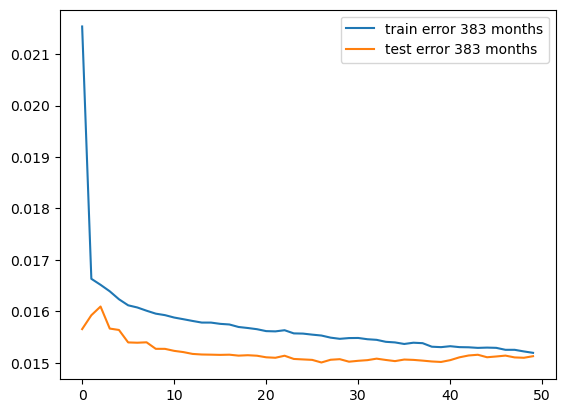

In [8]:
# Import the training class to train the model
from Models.training import Training

# Set the training parameters
epochs = 50

# Initialize the trainer
training = Training(my_lstm, X_train_tot, y_train_tot, X_test_tot, y_test_tot, epochs)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

In [9]:
# Load the state dictionary of the best performing model

my_lstm.load_state_dict(state_dict_list[best_epoch])

<All keys matched successfully>

In [10]:
# Save the model state dictionary for later use
Training.save_model(my_lstm, 'example_model')

AttributeError: type object 'Training' has no attribute 'save_model'

In [ ]:
# Forecast with the model
forecasts = my_lstm(X_test_tot.to(device))

In [ ]:
# Import the evaluation script
from src.evaluation.evaluation import Evaluation

# Evaluate the model performance
eval = Evaluation(y_test_tot.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# Show the evaluation metrics
eval.metrics()